### Could machine learning model help to choose the cast for a film?

This analysis aims to check if it is possible to assess which actors and directors influence the most the financial success of a film based on the model feature importances. Data for the analysis comes from Kaggle and data.world and was used in the general film features importance analysis: https://github.com/annadavy/Film_features_importance_for_revenue/blob/master/Film_features_importance_for_revenue.ipynb


In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import  metrics
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score,f1_score,classification_report
np.warnings.filterwarnings('ignore')

In [3]:
data=pd.read_csv('allFilms1.csv')
data=data.drop('Unnamed: 0',axis=1)
data=data.reset_index(drop=True)
data.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres_x,...,production_countries,release_date,revenue,runtime,spoken_languages,status,title,video,vote_average,vote_count
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2009.0,2.787965e+09,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Avatar,False,7.2,12114.0
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2007.0,9.610000e+08,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Pirates of the Caribbean: At World's End,False,6.9,4627.0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015.0,8.806746e+08,148.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,Spectre,False,6.3,4552.0
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2012.0,1.084939e+09,165.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Dark Knight Rises,False,7.6,9263.0
4,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2012.0,2.841391e+08,132.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,John Carter,False,6.1,2170.0


In [4]:
data.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres_x', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget_x', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'movie_facebook_likes', 'adult', 'budget_y', 'genres_y',
       'id', 'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'title', 'video', 'vote_average',
       'vote_count'],
      dtype='object')

__Creating a dataframe with the cast info:__

In [5]:
cast=data[['director_name','actor_2_name','actor_1_name','actor_3_name','budget_y','revenue']]

In [6]:
cast.head()

,director_name,actor_2_name,actor_1_name,actor_3_name,budget_y,revenue
0,James Cameron,Joel David Moore,CCH Pounder,Wes Studi,237000000,2.787965e+09
1,Gore Verbinski,Orlando Bloom,Johnny Depp,Jack Davenport,300000000,9.610000e+08
2,Sam Mendes,Rory Kinnear,Christoph Waltz,Stephanie Sigman,245000000,8.806746e+08
3,Christopher Nolan,Christian Bale,Tom Hardy,Joseph Gordon-Levitt,250000000,1.084939e+09
4,Andrew Stanton,Samantha Morton,Daryl Sabara,Polly Walker,260000000,2.841391e+08


In [7]:
cast.shape

(4458, 6)

In [8]:
cast=cast.drop_duplicates()

In [9]:
cast.shape

(4337, 6)

__Replacing all the budget values == 0 by budget mean in oreder to be able to calculate the result:__

In [11]:
cast.budget_y[cast.budget_y!=0].mean()

38154634.33446232

In [12]:
cast.budget_y[cast.budget_y==0]=cast.budget_y[cast.budget_y!=0].mean()

In [13]:
cast.budget_y.mean()

38154634.33446338

In [16]:
import seaborn as sns

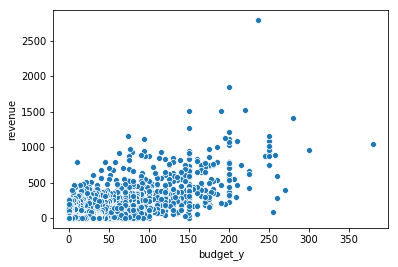

In [17]:
ax=sns.scatterplot(cast.budget_y/1000000,cast.revenue/1000000)

__Adding a 'result' and 'target' columns to check which film was a financial success:__

In [18]:
cast['result']=cast.revenue/cast.budget_y

In [19]:
cast.loc[cast['result'] >=2, 'target'] = 1
cast.loc[cast['result'] <2, 'target'] = 0

__Checking for NaN values:__

In [20]:
cast.isnull().sum()

director_name     0
actor_2_name      4
actor_1_name      3
actor_3_name     10
budget_y          0
revenue           0
result            0
target            0
dtype: int64

In [21]:
cast=cast.dropna()

In [22]:
cast.shape

(4327, 8)

__Using one hot encoding for all the actors and directors names:__

In [23]:
cast=pd.get_dummies(cast[cast.columns])

In [24]:
cast.head()

,budget_y,revenue,result,target,director_name_Aaron Hann,director_name_Aaron Seltzer,director_name_Abel Ferrara,director_name_Adam Brooks,director_name_Adam Carolla,director_name_Adam Goldberg,...,actor_3_name_Zhonghua Chen,actor_3_name_Zinedine Soualem,actor_3_name_Zoe Kazan,actor_3_name_Zoe Levin,actor_3_name_Zooey Deschanel,actor_3_name_Zoë Bell,actor_3_name_Zoë Kravitz,actor_3_name_Ángela Molina,actor_3_name_Émilie Dequenne,actor_3_name_Óscar Jaenada
0,237000000.0,2.787965e+09,11.763566,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,300000000.0,9.610000e+08,3.203333,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,245000000.0,8.806746e+08,3.594590,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,250000000.0,1.084939e+09,4.339756,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,260000000.0,2.841391e+08,1.092843,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


__Fitting the RandomForestClassifier:__

In [26]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import  metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score,f1_score,classification_report

In [27]:
X=cast.drop(['budget_y','revenue','result','target'],1)
y=cast.target

In [28]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.3, random_state=123)

In [29]:
pipe=Pipeline([("forest", RandomForestClassifier())])
               
param_grid={"forest__n_estimators":[300,500,1000],
            "forest__max_depth":[100,400,700]}

gs=GridSearchCV(pipe, param_grid,scoring='accuracy', cv=5, n_jobs=6)
gs.fit(X_train,y_train)

print(gs.best_params_)
print(gs.best_score_)
print(accuracy_score(gs.best_estimator_.predict(X_test),y_test))

{'forest__max_depth': 400, 'forest__n_estimators': 1000}
0.6235138705416117
0.6451116243264049


__Checking feature importances (in this case actors and directors influence on the film financial result) for the model with the best parameters:__

In [30]:
forest=RandomForestClassifier(n_estimators=300, max_depth=400,random_state=0,n_jobs=6)
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=400, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=6,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [32]:
importances=forest.feature_importances_
indices=np.argsort(importances)[::-1]
feat_labels=X.columns
for f in range(60):
    print("%2d)%-*s%f"%(f+1,30,feat_labels[indices[f]],importances[indices[f]]))

 1)director_name_Steven Spielberg0.006525
 2)actor_1_name_Tom Cruise       0.004091
 3)actor_1_name_Will Smith       0.003802
 4)actor_2_name_Morgan Freeman   0.003507
 5)director_name_Christopher Nolan0.003491
 6)director_name_Michael Bay     0.003353
 7)director_name_George A. Romero0.003153
 8)actor_1_name_Tom Hanks        0.002921
 9)actor_2_name_Thomas Kretschmann0.002858
10)actor_1_name_Robert Pattinson 0.002848
11)actor_2_name_Brad Pitt        0.002720
12)actor_1_name_Harrison Ford    0.002637
13)director_name_Quentin Tarantino0.002503
14)actor_1_name_Scarlett Johansson0.002482
15)director_name_Jon M. Chu      0.002448
16)director_name_M. Night Shyamalan0.002282
17)director_name_Rob Cohen       0.002248
18)actor_2_name_Matt Damon       0.002226
19)actor_1_name_Madeline Kahn    0.002225
20)director_name_David Lean      0.002221
21)director_name_Tom Shadyac     0.002115
22)director_name_Carlos Saldanha 0.002109
23)director_name_Shawn Levy      0.002061
24)director_name_Joel Schuma

In [36]:
import matplotlib as plt
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 7,12

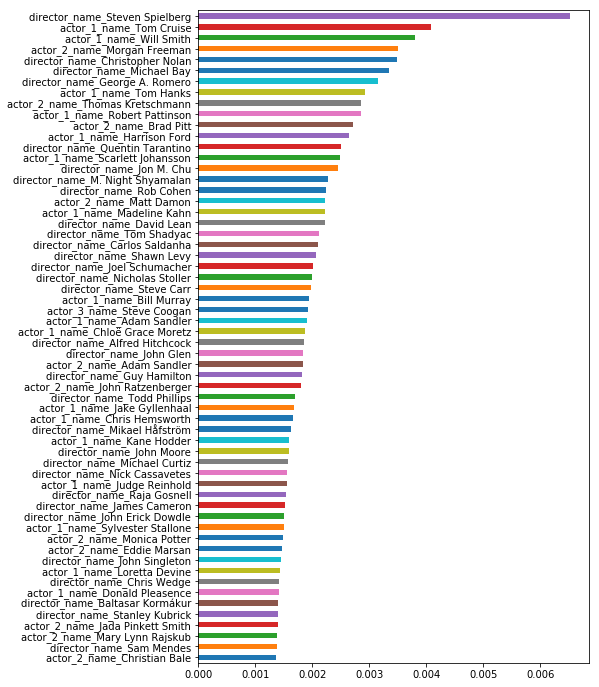

In [37]:
feat_importances = pd.Series(importances, index=X.columns)
feat_importances.nlargest(60).sort_values(ascending=True).plot(kind='barh')

__Checking if the most important features (actors and directors) are positively or negatively correlated with the target:__

In [38]:
actors=feat_importances.nlargest(60).index
actors

Index(['director_name_Steven Spielberg', 'actor_1_name_Tom Cruise',
       'actor_1_name_Will Smith', 'actor_2_name_Morgan Freeman',
       'director_name_Christopher Nolan', 'director_name_Michael Bay',
       'director_name_George A. Romero', 'actor_1_name_Tom Hanks',
       'actor_2_name_Thomas Kretschmann', 'actor_1_name_Robert Pattinson',
       'actor_2_name_Brad Pitt', 'actor_1_name_Harrison Ford',
       'director_name_Quentin Tarantino', 'actor_1_name_Scarlett Johansson',
       'director_name_Jon M. Chu', 'director_name_M. Night Shyamalan',
       'director_name_Rob Cohen', 'actor_2_name_Matt Damon',
       'actor_1_name_Madeline Kahn', 'director_name_David Lean',
       'director_name_Tom Shadyac', 'director_name_Carlos Saldanha',
       'director_name_Shawn Levy', 'director_name_Joel Schumacher',
       'director_name_Nicholas Stoller', 'director_name_Steve Carr',
       'actor_1_name_Bill Murray', 'actor_3_name_Steve Coogan',
       'actor_1_name_Adam Sandler', 'actor_1_na

In [39]:
corr=cast[['director_name_Steven Spielberg', 'actor_1_name_Tom Cruise',
       'actor_1_name_Will Smith', 'actor_2_name_Morgan Freeman',
       'director_name_Christopher Nolan', 'director_name_Michael Bay',
       'director_name_George A. Romero', 'actor_1_name_Tom Hanks',
       'actor_2_name_Thomas Kretschmann', 'actor_1_name_Robert Pattinson',
       'actor_2_name_Brad Pitt', 'actor_1_name_Harrison Ford',
       'director_name_Quentin Tarantino', 'actor_1_name_Scarlett Johansson',
       'director_name_Jon M. Chu', 'director_name_M. Night Shyamalan',
       'director_name_Rob Cohen', 'actor_2_name_Matt Damon',
       'actor_1_name_Madeline Kahn', 'director_name_David Lean',
       'director_name_Tom Shadyac', 'director_name_Carlos Saldanha',
       'director_name_Shawn Levy', 'director_name_Joel Schumacher',
       'director_name_Nicholas Stoller', 'director_name_Steve Carr',
       'actor_1_name_Bill Murray', 'actor_3_name_Steve Coogan',
       'actor_1_name_Adam Sandler', 'actor_1_name_Chloë Grace Moretz',
       'director_name_Alfred Hitchcock', 'director_name_John Glen',
       'actor_2_name_Adam Sandler', 'director_name_Guy Hamilton',
       'actor_2_name_John Ratzenberger', 'director_name_Todd Phillips',
       'actor_1_name_Jake Gyllenhaal', 'actor_1_name_Chris Hemsworth',
       'director_name_Mikael Håfström', 'actor_1_name_Kane Hodder',
       'director_name_John Moore', 'director_name_Michael Curtiz',
       'director_name_Nick Cassavetes', 'actor_1_name_Judge Reinhold',
       'director_name_Raja Gosnell', 'director_name_James Cameron',
       'director_name_John Erick Dowdle', 'actor_1_name_Sylvester Stallone',
       'actor_2_name_Monica Potter', 'actor_2_name_Eddie Marsan',
       'director_name_John Singleton', 'actor_1_name_Loretta Devine',
       'director_name_Chris Wedge', 'actor_1_name_Donald Pleasence',
       'director_name_Baltasar Kormákur', 'director_name_Stanley Kubrick',
       'actor_2_name_Jada Pinkett Smith', 'actor_2_name_Mary Lynn Rajskub',
       'director_name_Sam Mendes', 'actor_2_name_Christian Bale','target']].corr()

In [40]:
corr.target.sort_values(ascending=False)

target                              1.000000
actor_1_name_Tom Cruise             0.084073
director_name_Steven Spielberg      0.075853
actor_1_name_Tom Hanks              0.052385
director_name_Quentin Tarantino     0.052102
director_name_Christopher Nolan     0.052102
actor_1_name_Will Smith             0.051922
director_name_Michael Bay           0.051769
actor_1_name_Robert Pattinson       0.048731
actor_2_name_Matt Damon             0.048731
actor_2_name_Brad Pitt              0.045940
director_name_Raja Gosnell          0.045111
actor_2_name_John Ratzenberger      0.045111
director_name_Shawn Levy            0.042422
actor_1_name_Chloë Grace Moretz     0.042422
actor_2_name_Morgan Freeman         0.041679
actor_1_name_Sylvester Stallone     0.041679
actor_1_name_Madeline Kahn          0.041176
director_name_George A. Romero      0.041176
director_name_John Glen             0.041176
director_name_Jon M. Chu            0.041176
actor_2_name_Christian Bale         0.041176
director_n

### Dream Team for a film ;)

Combining the information about the feature importances and correlation we can assess which actors and directors have the most positive influence on a movie financial success. So according to the results obtained from this particular dataset the dream team for a film would be:

* Director: Steven Spielberg
* Actor in main role: Tom Cruise
* Actress in main role: Scarlett Johansson
* Actor in supporting role: Morgan Freeman
* Actress in supporting role: Monica Potter